In [1]:
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from doctr.io import DocumentFile
from doctr.models import ocr_predictor

def visualize_word_regions(image_path):
    # Read the image
    if isinstance(image_path, str):
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else:
        img = image_path.copy()
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Initialize the OCR predictor
    model = ocr_predictor(pretrained=True)
    
    # Save temporary image for doctr
    pil_image = Image.fromarray(img_rgb)
    temp_path = "temp_image.png"
    pil_image.save(temp_path)
    
    # Process with doctr
    doc = DocumentFile.from_images(temp_path)
    result = model(doc)
    
    # Create a copy for visualization
    viz_img = img_rgb.copy()
    
    # Draw boxes for each word
    for page in result.pages:
        for block in page.blocks:
            for line in block.lines:
                for word in line.words:
                    # Get coordinates
                    geometry = word.geometry
                    h, w = viz_img.shape[:2]
                    
                    # Convert relative coordinates to absolute pixels
                    x1 = int(geometry[0][0] * w)
                    y1 = int(geometry[0][1] * h)
                    x2 = int(geometry[1][0] * w)
                    y2 = int(geometry[1][1] * h)
                    
                    # Draw rectangle
                    cv2.rectangle(viz_img, (x1, y1), (x2, y2), (255, 0, 0), 2)
    
    # Plot the results
    plt.figure(figsize=(20, 20))
    plt.imshow(viz_img)
    plt.axis('off')
    plt.title('Detected Word Regions')
    plt.show()
    
    # Clean up
    import os
    if os.path.exists(temp_path):
        os.remove(temp_path)
        
    return viz_img

# Example usage (paste this in a separate cell):
# image_path = "path/to/your/document/image.jpg"
# visualized_image = visualize_word_regions(image_path)

C:\Users\skpc\Desktop\Projekts\temp\plgrzr\apps\plgrzr-trainer\.venv\Lib\site-packages\doctr\models\utils\pytorch.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_

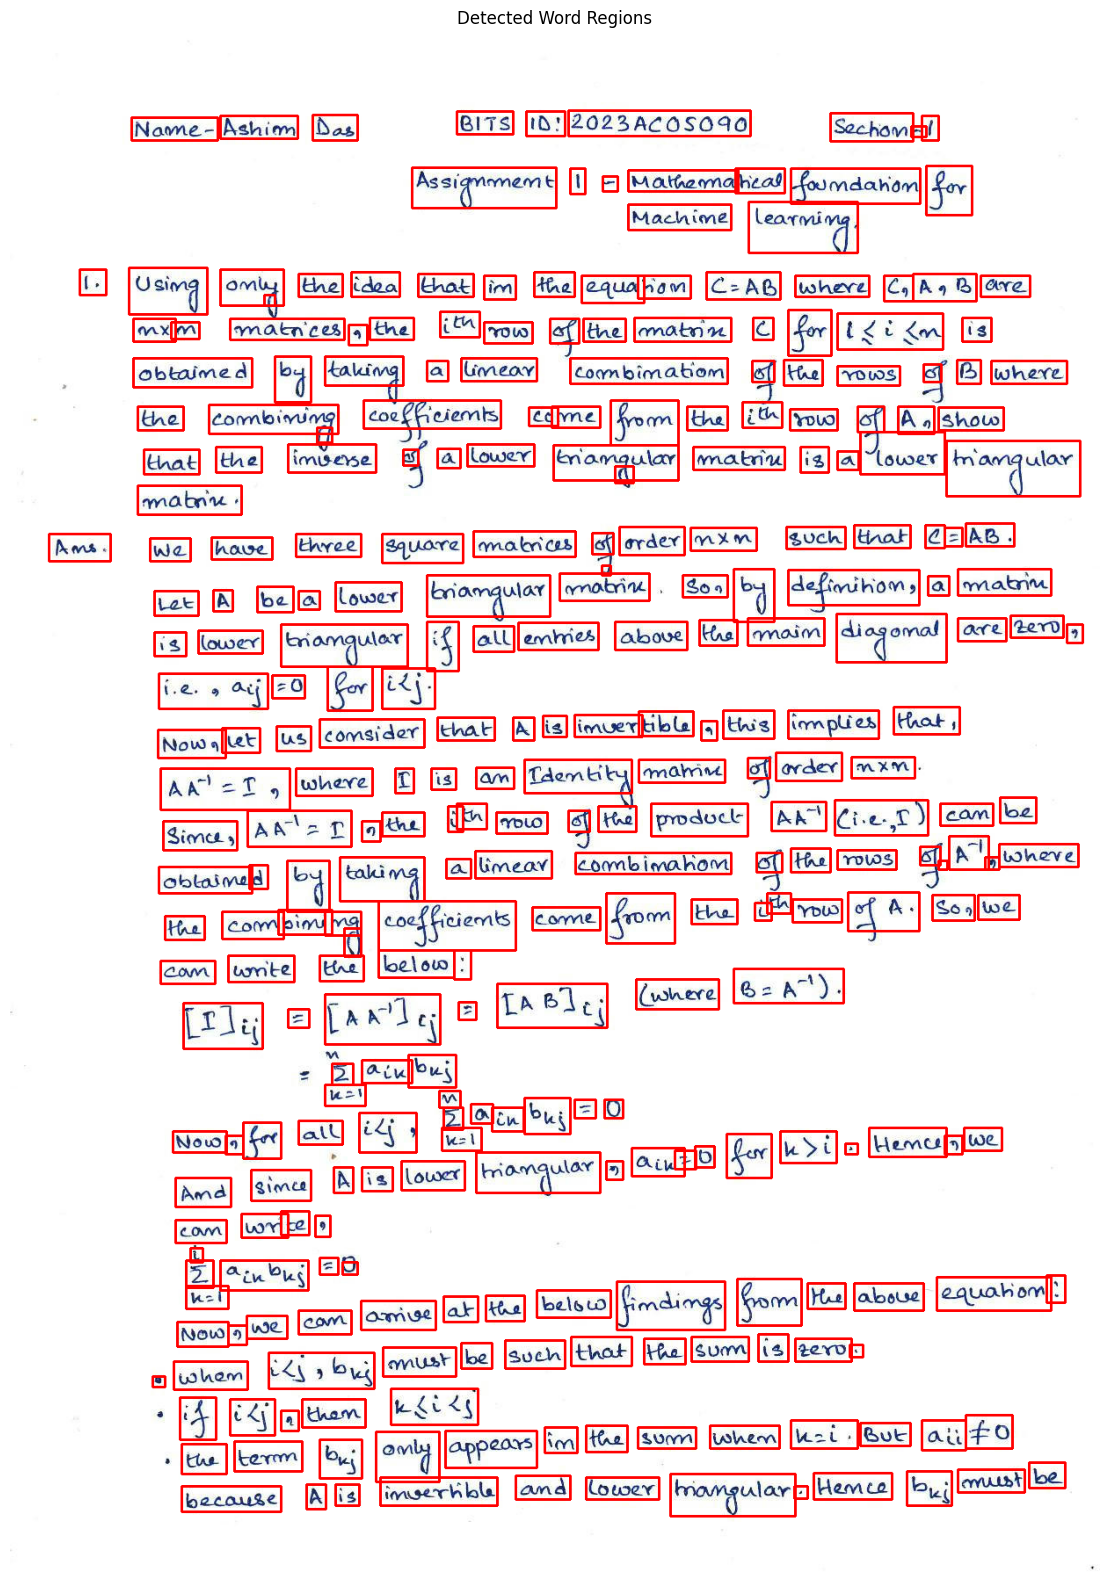

In [2]:
image_path = "../../data/plgrzr_output/prz_0kz7m6jv/prz_0kz7m6jv_2.jpg"
visualized_image = visualize_word_regions(image_path)

In [3]:
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from doctr.io import DocumentFile
from doctr.models import ocr_predictor

def visualize_largest_word_regions(image_path, num_regions=15):
    # Read the image
    if isinstance(image_path, str):
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else:
        img = image_path.copy()
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Initialize the OCR predictor
    model = ocr_predictor(pretrained=True)
    
    # Save temporary image for doctr
    pil_image = Image.fromarray(img_rgb)
    temp_path = "temp_image.png"
    pil_image.save(temp_path)
    
    # Process with doctr
    doc = DocumentFile.from_images(temp_path)
    result = model(doc)
    
    # Create a copy for visualization
    viz_img = img_rgb.copy()
    h, w = viz_img.shape[:2]
    
    # Collect all word regions with their areas
    word_regions = []
    for page in result.pages:
        for block in page.blocks:
            for line in block.lines:
                for word in line.words:
                    geometry = word.geometry
                    x1 = int(geometry[0][0] * w)
                    y1 = int(geometry[0][1] * h)
                    x2 = int(geometry[1][0] * w)
                    y2 = int(geometry[1][1] * h)
                    
                    # Calculate area
                    area = (x2 - x1) * (y2 - y1)
                    word_regions.append({
                        'coords': (x1, y1, x2, y2),
                        'area': area,
                        'text': word.value
                    })
    
    # Sort regions by area and get the largest ones
    word_regions.sort(key=lambda x: x['area'], reverse=True)
    largest_regions = word_regions[:num_regions]
    
    # Draw boxes and labels for the largest regions
    colors = plt.cm.rainbow(np.linspace(0, 1, num_regions))
    colors = (colors[:, :3] * 255).astype(int)
    
    for idx, region in enumerate(largest_regions):
        x1, y1, x2, y2 = region['coords']
        color = tuple(map(int, colors[idx]))
        
        # Draw rectangle
        cv2.rectangle(viz_img, (x1, y1), (x2, y2), color, 2)
        
        # Add label with size rank
        label = f"#{idx+1}"
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.8
        thickness = 2
        text_size = cv2.getTextSize(label, font, font_scale, thickness)[0]
        
        # Position the label above the box
        text_x = x1
        text_y = y1 - 5  # 5 pixels above the box
        
        # Add white background for text
        cv2.rectangle(viz_img, 
                     (text_x, text_y - text_size[1] - 5),
                     (text_x + text_size[0], text_y + 5),
                     (255, 255, 255),
                     -1)
        
        # Add text
        cv2.putText(viz_img, label, (text_x, text_y), 
                    font, font_scale, color, thickness)
    
    # Plot the results
    plt.figure(figsize=(20, 20))
    plt.imshow(viz_img)
    plt.axis('off')
    plt.title(f'{num_regions} Largest Word Regions')
    plt.show()
    
    # Clean up
    import os
    if os.path.exists(temp_path):
        os.remove(temp_path)
    
    # Return both the visualized image and the region data
    return viz_img, largest_regions

# Example usage (paste this in a separate cell):
# image_path = "path/to/your/document/image.jpg"
# visualized_image, regions = visualize_largest_word_regions(image_path)

# To print the detected text for each region:
# for idx, region in enumerate(regions):
#     print(f"Region #{idx+1}: {region['text']} (Area: {region['area']} pixels)")

In [4]:
image_path = "../../data/plgrzr_output/prz_0kz7m6jv/prz_0kz7m6jv_2.jpg"

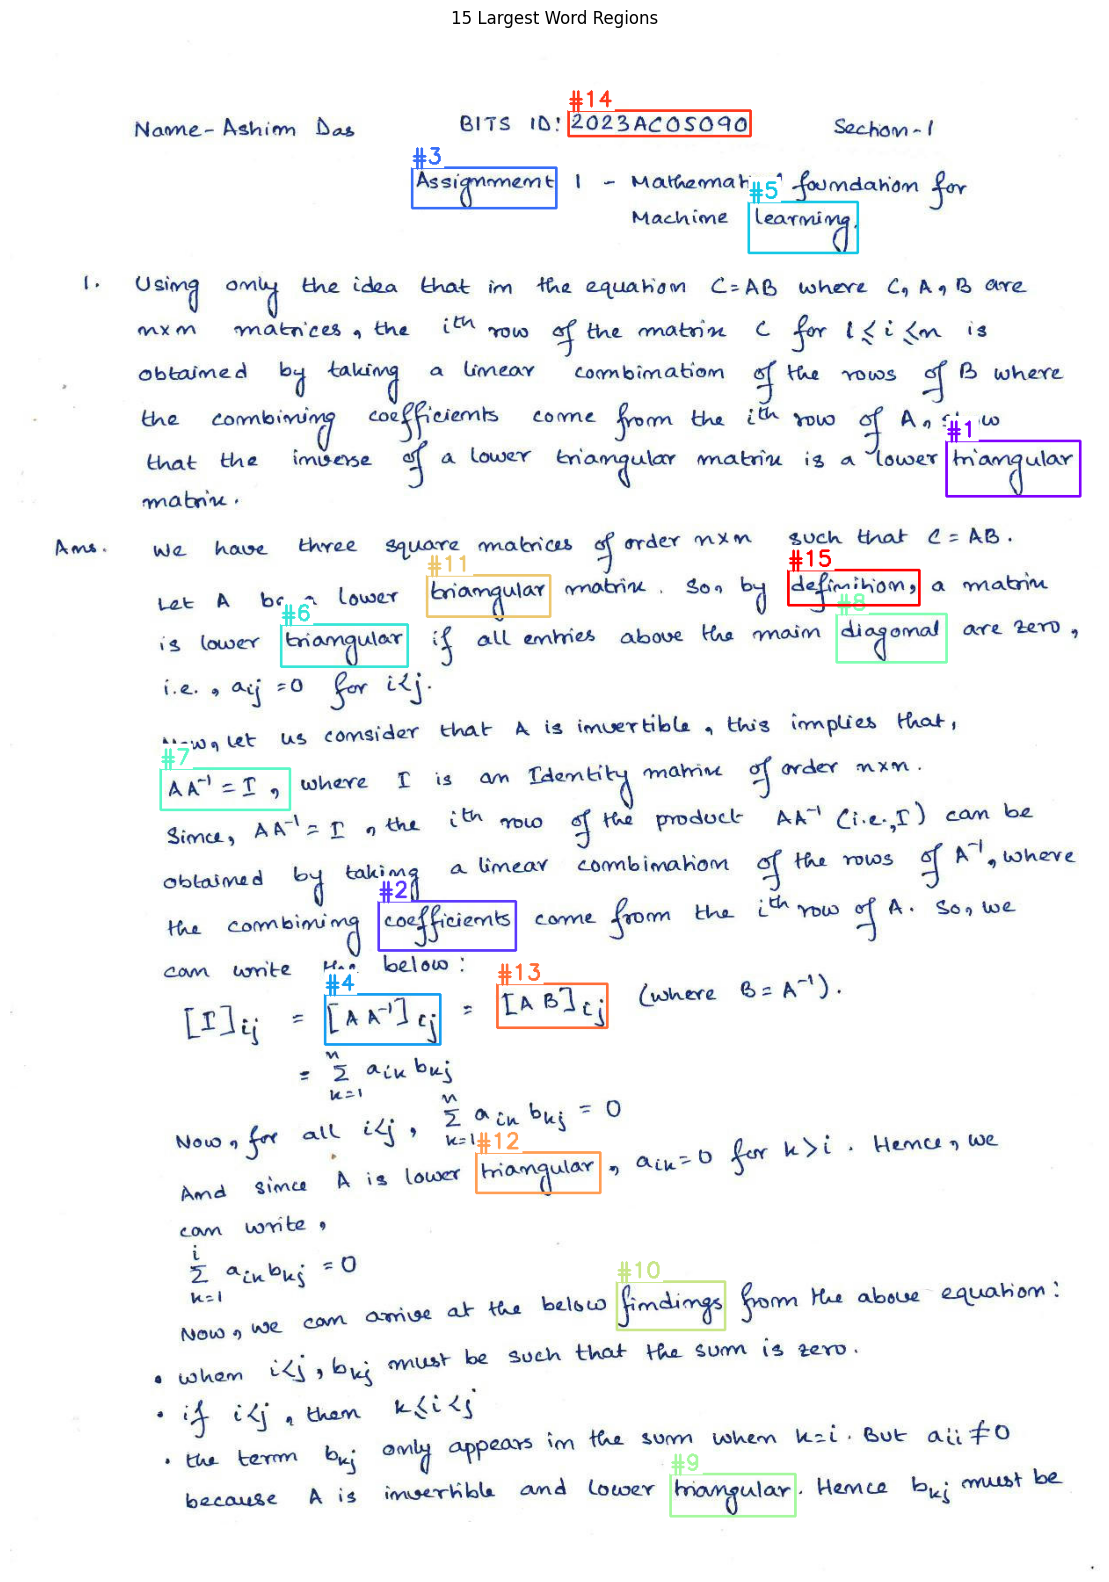

In [5]:
visualized_image, regions = visualize_largest_word_regions(image_path)

In [ ]:
for idx, region in enumerate(regions):
    print(f"Region #{idx+1}: {region['text']} (Area: {region['area']} pixels)")